# Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')

import os
import tensorflow as tf
import keras
import cv2

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers , models, optimizers

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.applications import ResNet50V2

The following code block imports essential libraries needed for this project:
- `pandas` for data manipulation and analysis.
- `numpy` for numerical computations.
- `matplotlib` and `seaborn` for data visualization.
- `tensorflow` and `keras` for building and training deep learning models.
- `cv2` (OpenCV) for image processing tasks.

# **Visualizing Classes**

In [ ]:
import os
import pandas as pd

# Use absolute paths
base_dir = os.path.expanduser('~/Downloads/EmotionBasedMusicRecommendationSystem/EmotionBasedMusicRecommendationSystem/dataset')
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

def Classes_Count(path, name):
    Classes_Dict = {}

    for Class in os.listdir(path):
        Full_Path = os.path.join(path, Class)
        Classes_Dict[Class] = len(os.listdir(Full_Path))

    df = pd.DataFrame(Classes_Dict, index=[name])

    return df

Train_Count = Classes_Count(train_dir, 'Train').transpose().sort_values(by="Train", ascending=False)
Test_Count = Classes_Count(test_dir, 'Test').transpose().sort_values(by="Test", ascending=False)

print("Train Count:\n", Train_Count)
print("Test Count:\n", Test_Count)

Train Count:
           Train
happy      7215
neutral    4965
sad        4830
fear       4097
angry      3995
surprise   3171
disgust     436
Test Count:
           Test
happy     1774
sad       1247
neutral   1233
fear      1024
angry      958
surprise   831
disgust    111


### Loading Emotion Detection Dataset
This code block loads the emotion detection dataset from a CSV file into a pandas DataFrame. The dataset consists of 35,685 grayscale images of faces, each labeled with one of seven emotions: happiness, neutral, sadness, anger, surprise, disgust, and fear. The images are stored as flattened arrays in the CSV file, and we will later reshape them into 48x48 pixel images.

In [ ]:
pd.concat([Train_Count,Test_Count] , axis=1)

,Train,Test
happy,7215,1774
neutral,4965,1233
sad,4830,1247
fear,4097,1024
angry,3995,958
surprise,3171,831
disgust,436,111


<Axes: >

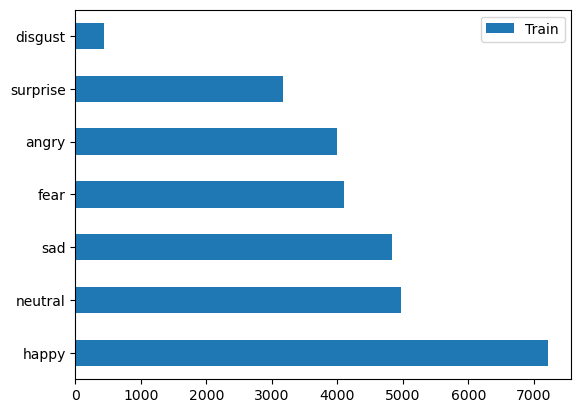

In [ ]:
Train_Count.plot(kind='barh')

<Axes: >

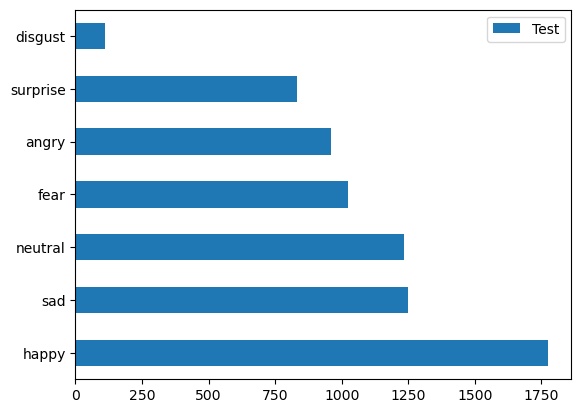

In [ ]:
Test_Count.plot(kind='barh')

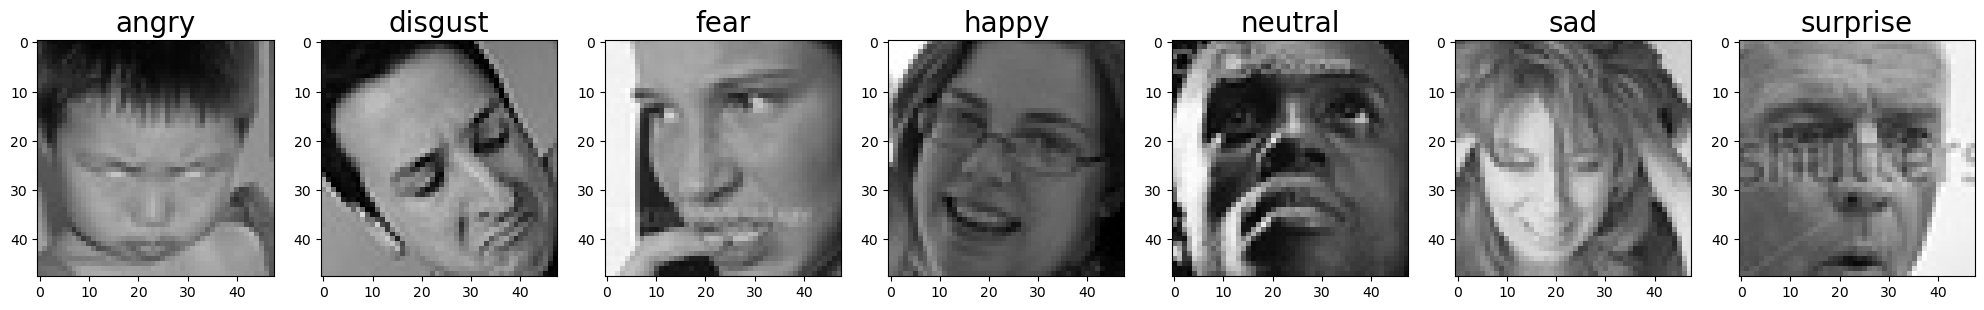

In [ ]:
plt.style.use('default')
plt.figure(figsize = (25, 8))
image_count = 1
# Use the correct path
BASE_URL = os.path.expanduser('~/Downloads/EmotionBasedMusicRecommendationSystem/EmotionBasedMusicRecommendationSystem/dataset/train/')


for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(1, 7, image_count)
                image_count += 1
                image = cv2.imread(BASE_URL + directory + '/' + file)
                plt.imshow(image)
                plt.title(directory, fontsize = 20)

# **Data Preprocessing**

### Data Preprocessing
The following code block performs several preprocessing steps on the emotion detection dataset:
- Reshaping the flattened image arrays into 48x48 pixel images.
- Normalizing the pixel values to the range [0, 1].
- Converting the emotion labels to one-hot encoded vectors.
- Splitting the data into training and test sets.
Data augmentation techniques such as rotation and flipping are also applied to increase the diversity of the training set and improve the model's robustness.

In [ ]:
img_shape = 48
batch_size = 64
base_dir = os.path.expanduser('~/Downloads/EmotionBasedMusicRecommendationSystem/EmotionBasedMusicRecommendationSystem/dataset')
train_data_path = os.path.join(base_dir, 'train')
test_data_path = os.path.join(base_dir, 'test')

In [ ]:
train_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
        # Data Augmentation
        rotation_range=10,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest',
    )


test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

train_data = train_preprocessor.flow_from_directory(
    train_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size,
    subset='training',
)


test_data = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size,
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# **Building CNN Model**

### Defining the CNN Model
This code block defines a simple Convolutional Neural Network (CNN) architecture for emotion detection. The model consists of:
- Convolutional layers with ReLU activation to extract features from the images.
- Max-pooling layers to reduce the spatial dimensions and computational load.
- Fully connected layers to perform the classification.
- A softmax output layer to provide probabilities for each emotion category.

In [ ]:
def Create_CNN_Model():

    model = Sequential()

    #CNN1
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=(img_shape, img_shape, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(64,(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.25))

    #CNN2
    model.add(Conv2D(64, (3,3), activation='relu', ))
    model.add(BatchNormalization())
    model.add(Conv2D(128,(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.25))

    #CNN3
    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(256,(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.25))


    #Output
    model.add(Flatten())

    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(7,activation='softmax'))


    return model

In [ ]:
CNN_Model = Create_CNN_Model()

CNN_Model.summary()

CNN_Model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

C:\Users\Manahil\Anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 46, 46, 32)        │        896 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_12          │ (None, 46, 46, 32)        │        128 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_7 (Conv2D)               │ (None, 46, 46, 64)        │     18,496 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_13          │ (None, 46, 46, 64)        │        256 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 23, 23, 64)        │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_9 (Dropout)             │ (None, 23, 23, 64)        │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_8 (Conv2D)               │ (None, 21, 21, 64)        │     36,928 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_14          │ (None, 21, 21, 64)        │        256 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_9 (Conv2D)               │ (None, 21, 21, 128)       │     73,856 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_15          │ (None, 21, 21, 128)       │        512 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 11, 11, 128)       │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_10 (Dropout)            │ (None, 11, 11, 128)       │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_10 (Conv2D)              │ (None, 9, 9, 128)         │    147,584 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_16          │ (None, 9, 9, 128)         │        512 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_11 (Conv2D)              │ (None, 9, 9, 256)         │    295,168 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_17          │ (None, 9, 9, 256)         │      1,024 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 5, 5, 256)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_11 (Dropout)            │ (None, 5, 5, 256)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_1 (Flatten)             │ (None, 6400)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_7 (Dense)                 │ (None, 1024)              │  6,554,624 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_18          │ (None, 1024)              │      4,096 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼──────────

 Total params: 7,837,895 (29.90 MB)

 Trainable params: 7,832,519 (29.88 MB)

 Non-trainable params: 5,376 (21.00 KB)

**Specifying Callbacks**

### Training the CNN Model
The following code block trains the CNN model on the preprocessed emotion detection dataset. The training process involves:
- Specifying the loss function and optimizer.
- Training the model for a set number of epochs.
- Monitoring the training and validation accuracy and loss to evaluate the model's performance.

In [ ]:
# Create Callback Checkpoint with .keras extension
checkpoint_path = "CNN_Model_Checkpoint.keras"

Checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True)

# Create Early Stopping Callback to monitor the accuracy
Early_Stopping = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True, verbose=1)
# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning rate
Reducing_LR = tf.keras.callbacks.ReduceLROnPlateau( monitor='val_loss',
                                                  factor=0.2,
                                                  patience=2,
#                                                   min_lr=0.000005,
                                                  verbose=1)

callbacks = [Early_Stopping, Reducing_LR]

steps_per_epoch = train_data.n // train_data.batch_size
validation_steps = test_data.n // test_data.batch_size

In [ ]:
# Create Callback Checkpoint with .keras extension
checkpoint_path = "CNN_Model_Checkpoint.keras"

Checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True)

# Create Early Stopping Callback with increased patience
Early_Stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1)

# Create ReduceLROnPlateau Callback with adjusted parameters
Reducing_LR = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  # Reduce learning rate by a smaller factor
    patience=5,  # Allow more epochs before reducing learning rate
    min_lr=1e-7,  # Set a minimum learning rate
    verbose=1
)

callbacks = [Checkpoint, Early_Stopping, Reducing_LR]

steps_per_epoch = train_data.n // train_data.batch_size
validation_steps = test_data.n // test_data.batch_size

In [ ]:

CNN_history = CNN_Model.fit(
    train_data,
    validation_data=test_data,
    epochs=50,
    batch_size=batch_size,
    callbacks=callbacks,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
)

Epoch 1/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 170s 378ms/step - accuracy: 0.4174 - loss: 1.5009 - val_accuracy: 0.4641 - val_loss: 1.3697 - learning_rate: 4.0960e-12
Epoch 2/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 850us/step - accuracy: 0.4844 - loss: 0.6648 - val_accuracy: 1.0000 - val_loss: 0.1495 - learning_rate: 4.0960e-12
Epoch 3/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 169s 376ms/step - accuracy: 0.4205 - loss: 1.4986 - val_accuracy: 0.4637 - val_loss: 1.3676 - learning_rate: 4.0960e-12
Epoch 4/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 91us/step - accuracy: 0.5156 - loss: 0.6330 - val_accuracy: 1.0000 - val_loss: 0.1549 - learning_rate: 4.0960e-12
Epoch 5/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 169s 377ms/step - accuracy: 0.4180 - loss: 1.5013 - val_accuracy: 0.4634 - val_loss: 1.3691 - learning_rate: 4.0960e-12
Epoch 6/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 97us/step - accuracy: 0.3906 - loss: 0.7524 - val_accuracy: 1.0000 - val_loss: 0.1527 - learning_rate: 4.0960e-12
Epoch 7/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 169s 375

In [ ]:
CNN_history = CNN_Model.fit( train_data , validation_data= test_data , epochs=50, batch_size= batch_size,
                            callbacks=callbacks, steps_per_epoch= steps_per_epoch, validation_steps=validation_steps)

Epoch 1/50


C:\Users\Manahil\Anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


448/448 ━━━━━━━━━━━━━━━━━━━━ 387s 841ms/step - accuracy: 0.1815 - loss: 2.2515 - val_accuracy: 0.2476 - val_loss: 1.8167 - learning_rate: 0.0010
Epoch 2/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step - accuracy: 0.3125 - loss: 0.9515 - val_accuracy: 0.0000e+00 - val_loss: 1.2859 - learning_rate: 0.0010
Epoch 3/50


C:\Users\Manahil\Anaconda3\lib\contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


448/448 ━━━━━━━━━━━━━━━━━━━━ 170s 378ms/step - accuracy: 0.2561 - loss: 1.8149 - val_accuracy: 0.3382 - val_loss: 1.6323 - learning_rate: 0.0010
Epoch 4/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 139us/step - accuracy: 0.2812 - loss: 0.8686 - val_accuracy: 0.6000 - val_loss: 0.5756 - learning_rate: 0.0010
Epoch 5/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 174s 386ms/step - accuracy: 0.3348 - loss: 1.6723 - val_accuracy: 0.4018 - val_loss: 1.5488 - learning_rate: 0.0010
Epoch 6/50
  1/448 ━━━━━━━━━━━━━━━━━━━━ 2:44 369ms/step - accuracy: 0.3281 - loss: 1.6830
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 105us/step - accuracy: 0.3281 - loss: 0.8434 - val_accuracy: 0.5000 - val_loss: 0.7428 - learning_rate: 0.0010
Epoch 7/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 378s 837ms/step - accuracy: 0.4074 - loss: 1.5362 - val_accuracy: 0.4563 - val_loss: 1.3966 - learning_rate: 2.0000e-04
Epoch 8/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 125us/step - accuracy: 0.4054 - 

# **Evaluating CNN Model**

### Evaluating the CNN Model
This code block evaluates the trained CNN model on the test set and prints the accuracy. Additionally, a confusion matrix is generated to visualize the model's performance across different emotion categories, highlighting the true positives, false positives, and false negatives.


In [ ]:
CNN_Score = CNN_Model.evaluate(test_data)

print("    Test Loss: {:.5f}".format(CNN_Score[0]))
print("Test Accuracy: {:.2f}%".format(CNN_Score[1] * 100))

113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step - accuracy: 0.2934 - loss: 1.6286
    Test Loss: 1.36009
Test Accuracy: 46.46%


In [ ]:
def plot_curves(history):

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))

    plt.figure(figsize=(15,5))

    #plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label = "training_loss")
    plt.plot(epochs, val_loss, label = "val_loss")
    plt.title("Loss")
    plt.xlabel("epochs")
    plt.legend()

    #plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label = "training_accuracy")
    plt.plot(epochs, val_accuracy, label = "val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("epochs")
    plt.legend()

  #plt.tight_layout()

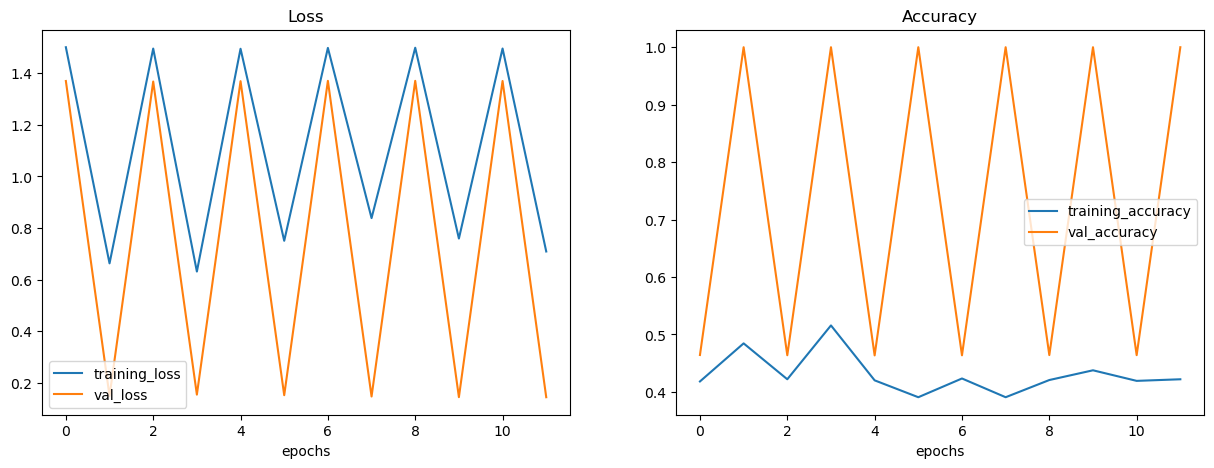

In [ ]:
plot_curves(CNN_history)

In [ ]:
CNN_Predictions = CNN_Model.predict(test_data)

# Choosing highest probalbilty class in every prediction
CNN_Predictions = np.argmax(CNN_Predictions, axis=1)

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step


In [ ]:
test_data.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

Text(0.5, 1.0, 'CNN Confusion Matrix')

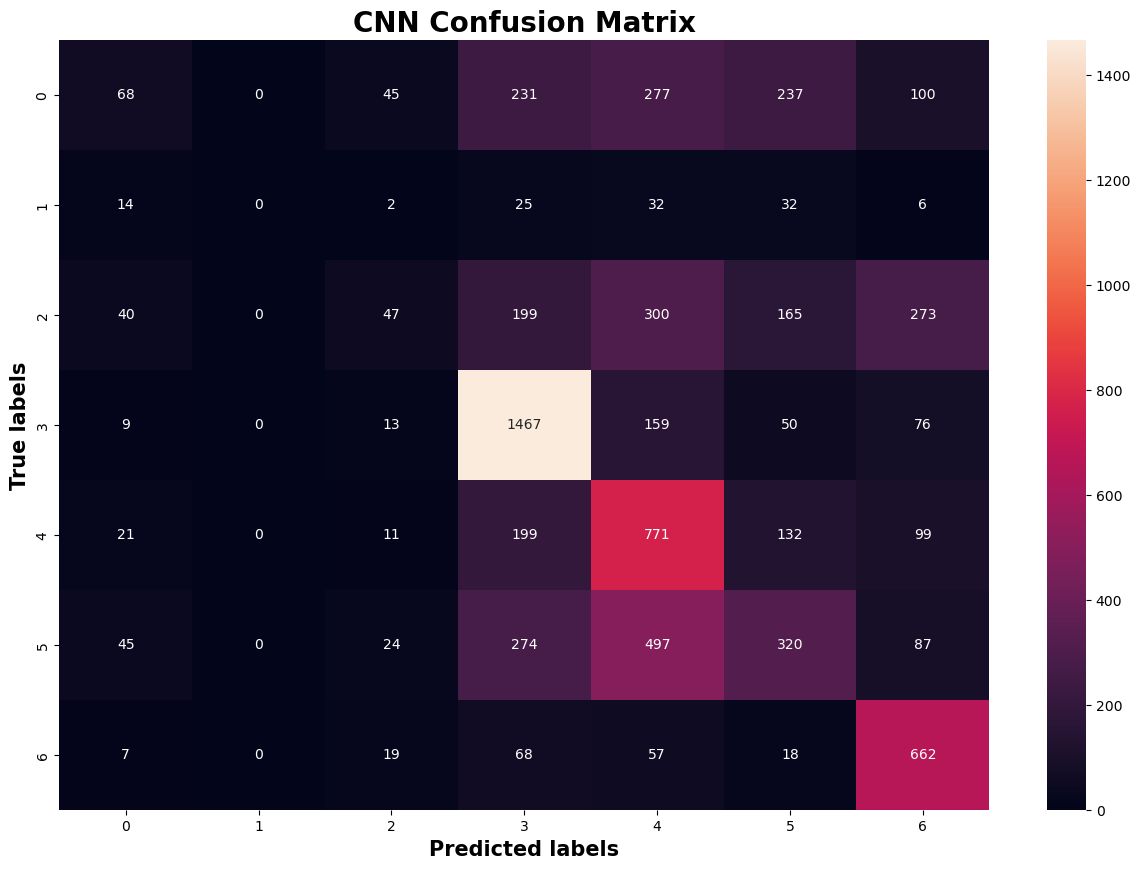

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

fig, ax= plt.subplots(figsize=(15,10))

cm=confusion_matrix(test_data.labels, CNN_Predictions)

sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels',fontsize=15, fontweight='bold')
ax.set_ylabel('True labels', fontsize=15, fontweight='bold')
ax.set_title('CNN Confusion Matrix', fontsize=20, fontweight='bold')

# **ResNet50V2 Model**

### Defining the ResNet50V2 Model
This code block defines the ResNet50V2 model, a more advanced CNN architecture known for its high accuracy in image classification tasks. The ResNet50V2 model includes:
- Multiple residual blocks that allow the model to learn deeper representations without suffering from vanishing gradients.
- Batch normalization to stabilize and accelerate the training process.
- Global average pooling followed by fully connected layers for classification.
- A softmax output layer to provide probabilities for each emotion category.

In [ ]:
# specifing new image shape for resnet
img_shape = 224
batch_size = 64
base_dir = os.path.expanduser('~/Downloads/EmotionBasedMusicRecommendationSystem/EmotionBasedMusicRecommendationSystem/dataset')
train_data_path = os.path.join(base_dir, 'train')
test_data_path = os.path.join(base_dir, 'test')

In [ ]:
train_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
        rotation_range=10,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest',
    )


test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

train_data = train_preprocessor.flow_from_directory(
    train_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size,
    subset='training',
)

test_data = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size,
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# **Fine-Tuning ResNet50V2**

### Training the ResNet50V2 Model
The following code block trains the ResNet50V2 model on the emotion detection dataset. The training process involves:
- Compiling the model with an appropriate loss function and optimizer.
- Training the model for a set number of epochs while monitoring the training and validation accuracy and loss.
- Implementing early stopping to prevent overfitting and ensure the model generalizes well to unseen data.

In [ ]:
# 224,224,3
ResNet50V2 = tf.keras.applications.ResNet50V2(input_shape=(224, 224, 3),
                                               include_top= False,
                                               weights='imagenet'
                                               )

#ResNet50V2.summary()

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
# Freezing all layers except last 50

ResNet50V2.trainable = True

for layer in ResNet50V2.layers[:-50]:
    layer.trainable = False

In [ ]:
def Create_ResNet50V2_Model():

    model = Sequential([
                      ResNet50V2,
                      Dropout(.25),
                      BatchNormalization(),
                      Flatten(),
                      Dense(64, activation='relu'),
                      BatchNormalization(),
                      Dropout(.5),
                      Dense(7,activation='softmax')
                    ])
    return model

In [ ]:
ResNet50V2_Model = Create_ResNet50V2_Model()

ResNet50V2_Model.summary()

ResNet50V2_Model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ ?                         │ 23,564,800 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_18 (Dropout)            │ ?                         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_24          │ ?                         │          0 │
│ (BatchNormalization)            │                           │  (unbuilt) │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_2 (Flatten)             │ ?                         │          0 │
│                                 │                           │  (unbuilt) │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_14 (Dense)                │ ?                         │          0 │
│                                 │                           │  (unbuilt) │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_25          │ ?                         │          0 │
│ (BatchNormalization)            │                           │  (unbuilt) │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_19 (Dropout)            │ ?                         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_15 (Dense)                │ ?                         │          0 │
│                                 │                           │  (unbuilt) │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 23,564,800 (89.89 MB)

 Trainable params: 16,352,256 (62.38 MB)

 Non-trainable params: 7,212,544 (27.51 MB)

**Specifying Callbacks**

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:

# Create Callback Checkpoint with .keras extension
checkpoint_path = "ResNet50V2_Model_Checkpoint.keras"

Checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True)

# Create Early Stopping Callback to monitor the accuracy
Early_Stopping = EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True, verbose=1)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning
Reducing_LR = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    verbose=1
)

callbacks = [Checkpoint, Early_Stopping, Reducing_LR]

steps_per_epoch = train_data.n // train_data.batch_size
validation_steps = test_data.n // test_data.batch_size


In [ ]:
ResNet50V2_history = ResNet50V2_Model.fit(train_data ,validation_data = test_data , epochs=30, batch_size=batch_size,
                                         callbacks = callbacks, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)

Epoch 1/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 1713s 4s/step - accuracy: 0.5646 - loss: 1.2042 - val_accuracy: 0.6116 - val_loss: 1.0464 - learning_rate: 0.0010
Epoch 2/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6094 - loss: 0.6157 - val_accuracy: 0.9000 - val_loss: 0.1935 - learning_rate: 0.0010
Epoch 3/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 1665s 4s/step - accuracy: 0.6088 - loss: 1.0765 - val_accuracy: 0.6027 - val_loss: 1.0723 - learning_rate: 0.0010
Epoch 4/30
  1/448 ━━━━━━━━━━━━━━━━━━━━ 23:02 3s/step - accuracy: 0.6875 - loss: 0.8622
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
448/448 ━━━━━━━━━━━━━━━━━━━━ 4s 909us/step - accuracy: 0.6875 - loss: 0.4321 - val_accuracy: 0.9000 - val_loss: 0.2329 - learning_rate: 0.0010
Epoch 5/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 1635s 4s/step - accuracy: 0.6343 - loss: 1.0042 - val_accuracy: 0.6543 - val_loss: 0.9410 - learning_rate: 2.0000e-04
Epoch 6/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 4s 917us/step - accuracy: 0.6406 -

# **Evaluating ResNet50V2**

### Evaluating the ResNet50V2 Model
This code block evaluates the ResNet50V2 model on the test set and prints the evaluation metrics, including accuracy, precision, recall, and F1-score. A confusion matrix is generated to provide a detailed breakdown of the model's performance across different emotion categories.


In [ ]:
ResNet50V2_Score = ResNet50V2_Model.evaluate(test_data)

print("    Test Loss: {:.5f}".format(ResNet50V2_Score[0]))
print("Test Accuracy: {:.2f}%".format(ResNet50V2_Score[1] * 100))

113/113 ━━━━━━━━━━━━━━━━━━━━ 211s 2s/step - accuracy: 0.6103 - loss: 1.0180
    Test Loss: 0.92925
Test Accuracy: 65.34%


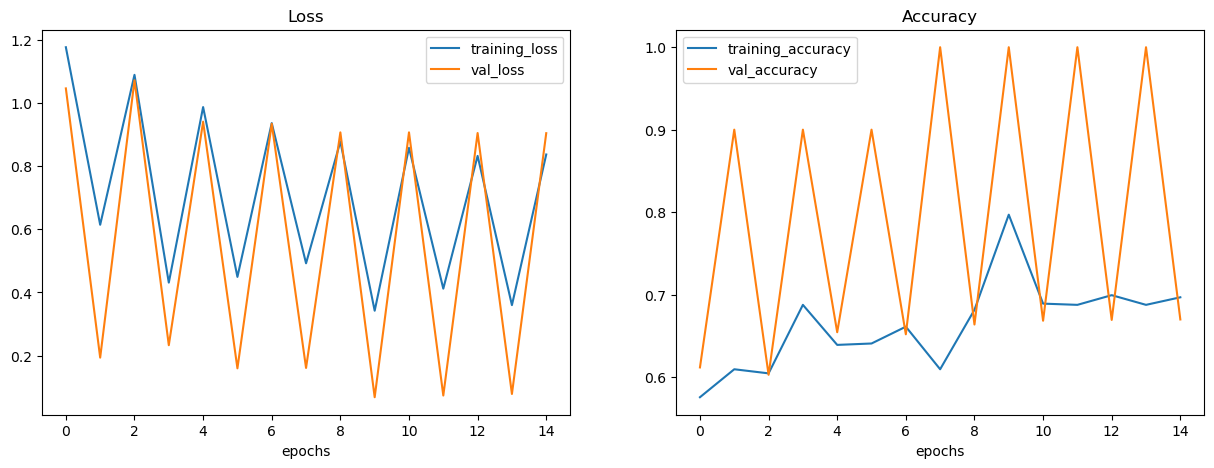

In [ ]:
plot_curves(ResNet50V2_history)

In [ ]:
ResNet50V2_Predictions = ResNet50V2_Model.predict(test_data)

# Choosing highest probalbilty class in every prediction
ResNet50V2_Predictions = np.argmax(ResNet50V2_Predictions, axis=1)

113/113 ━━━━━━━━━━━━━━━━━━━━ 214s 2s/step


Text(0.5, 1.0, 'ResNet50V2 Confusion Matrix')

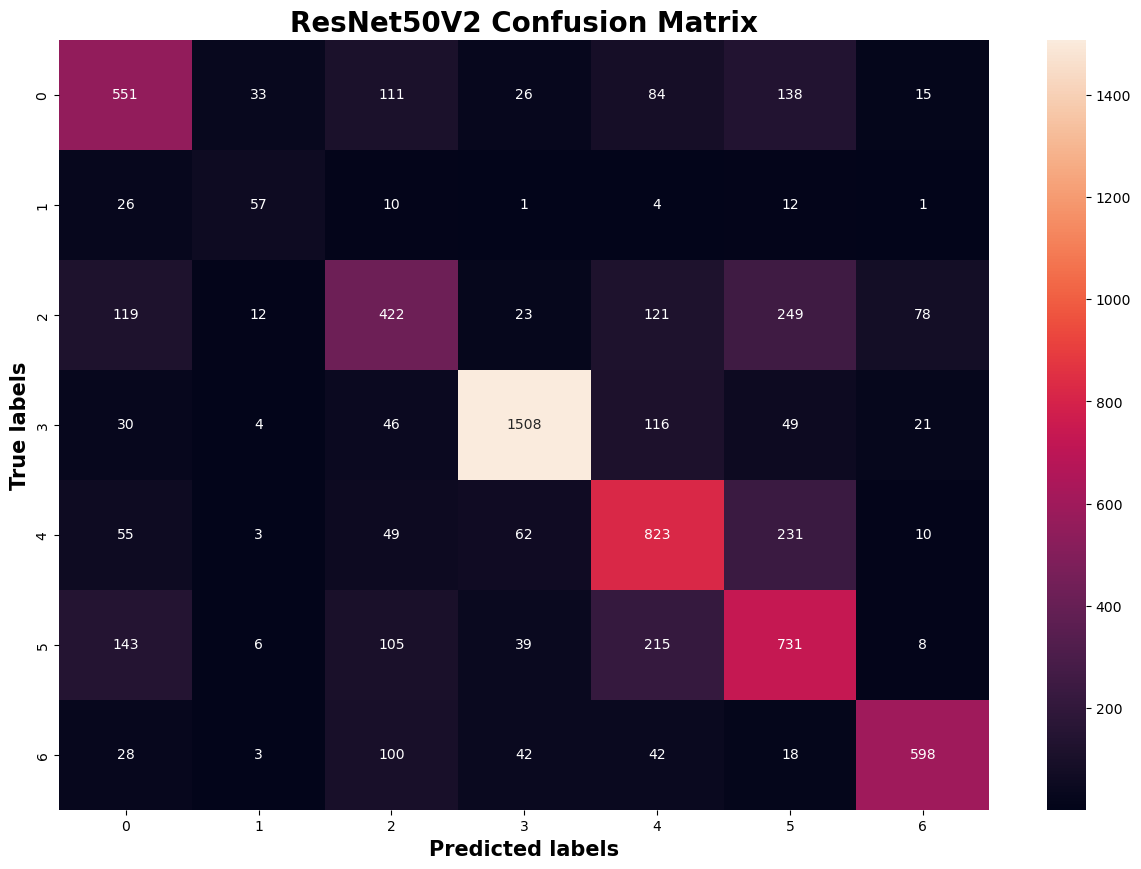

In [ ]:
fig , ax= plt.subplots(figsize=(15,10))

cm=confusion_matrix(test_data.labels, ResNet50V2_Predictions)

sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels',fontsize=15, fontweight='bold')
ax.set_ylabel('True labels', fontsize=15, fontweight='bold')
ax.set_title('ResNet50V2 Confusion Matrix', fontsize=20, fontweight='bold')

# **Visualizing Predictions**

In [ ]:
Emotion_Classes = ['Angry',
                  'Disgust',
                  'Fear',
                  'Happy',
                  'Neutral',
                  'Sad',
                  'Surprise']

In [ ]:
# Shuffling Test Data to show diffrent classes
test_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
    )

test_generator = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=True,
    batch_size=batch_size,
)

Found 7178 images belonging to 7 classes.


**ResNet50V2 Predictions**

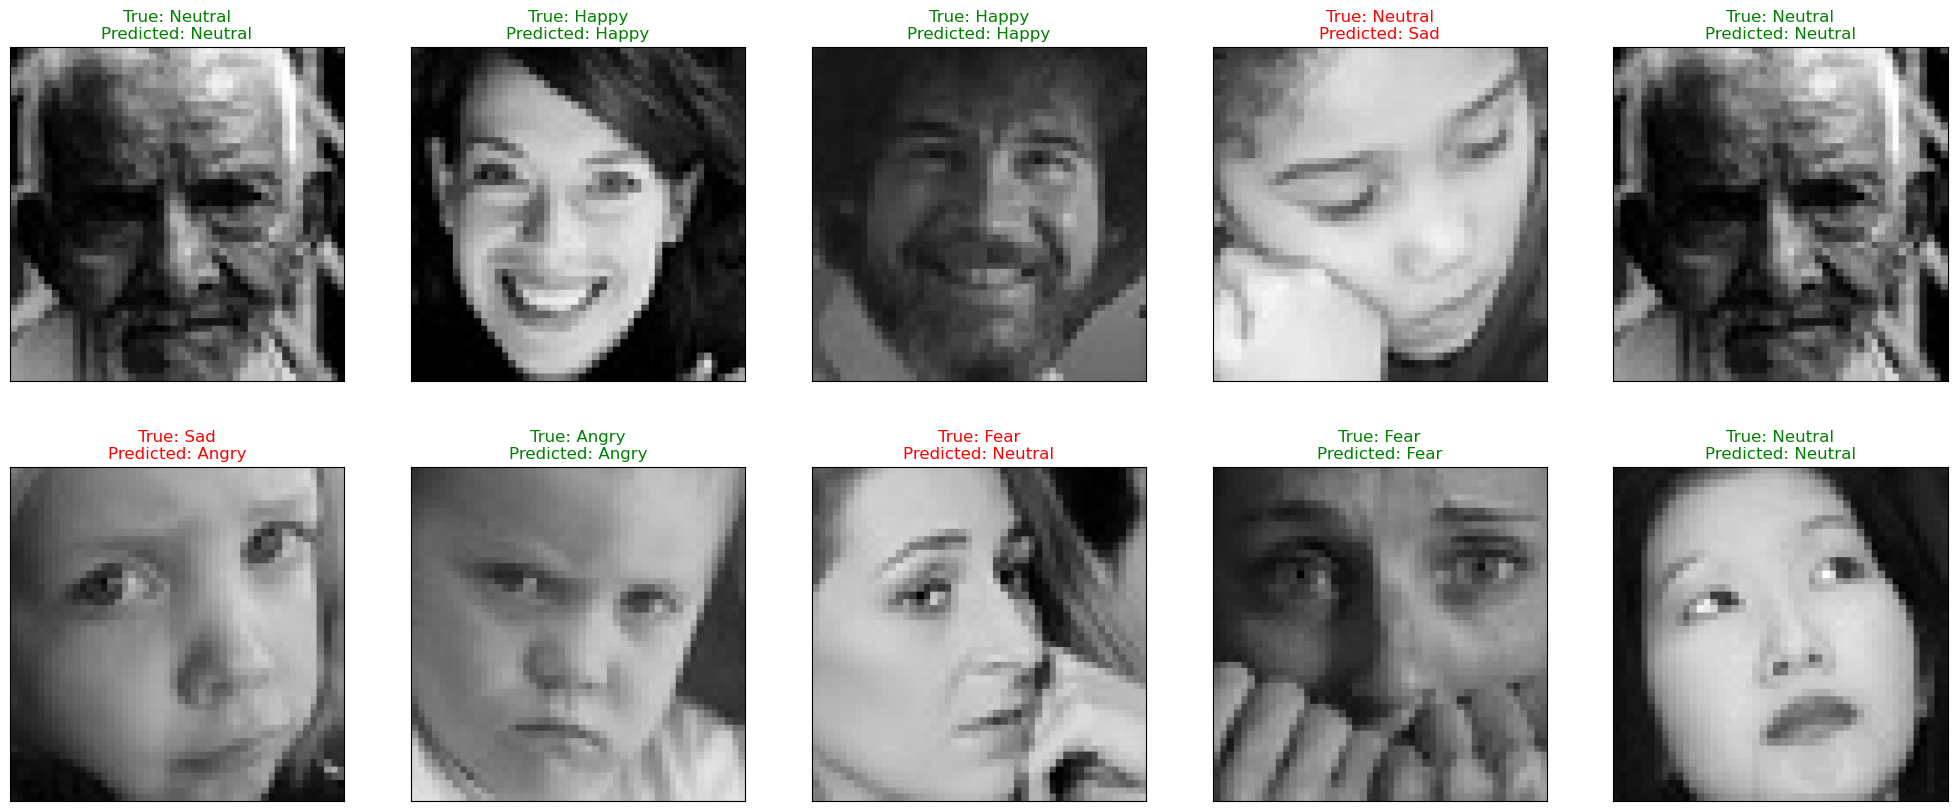

<Figure size 640x480 with 0 Axes>

In [ ]:
# Display 10 random pictures from the dataset with their labels

Random_batch = np.random.randint(0, len(test_generator) - 1)

Random_Img_Index = np.random.randint(0, batch_size - 1 , 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):

    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]

    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]])

    Model_Prediction = np.argmax(ResNet50V2_Model.predict( tf.expand_dims(Random_Img, axis=0) , verbose=0))

    ax.imshow(Random_Img)

    if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction]:
          color = "green"
    else:
          color = "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)
plt.show()
plt.tight_layout()

# **Music Recommendation**

### Music Recommendation System
This code block defines the logic for the music recommendation system based on detected emotions. The system uses the Spotify music dataset, which contains metadata for various songs. The recommendation algorithm:
- Maps detected emotions to specific subsets of the Spotify dataset.
- Selects five songs from the relevant subset based on features such as energy, valence, and tempo.
- For example, if the detected emotion is anger, the system recommends calming and soothing tracks; if the emotion is happiness, it suggests joyful and lively songs.

In [ ]:
Music_Player = pd.read_csv("~/Downloads/EmotionBasedMusicRecommendationSystem/EmotionBasedMusicRecommendationSystem/dataset/data_moods.csv")
Music_Player = Music_Player[['name','artist','mood','popularity']]
Music_Player.head()

,name,artist,mood,popularity
0,1999,Prince,Happy,68
1,23,Blonde Redhead,Sad,43
2,9 Crimes,Damien Rice,Sad,60
3,99 Luftballons,Nena,Happy,2
4,A Boy Brushed Red Living In Black And White,Underoath,Energetic,60


In [ ]:
Music_Player["mood"].value_counts()

mood
Sad          197
Calm         195
Energetic    154
Happy        140
Name: count, dtype: int64

In [ ]:
Music_Player["popularity"].value_counts()

popularity
0     92
51    23
52    22
50    21
55    21
      ..
80     1
2      1
14     1
15     1
88     1
Name: count, Length: 83, dtype: int64

In [ ]:
Play = Music_Player[Music_Player['mood'] =='Calm' ]
Play = Play.sort_values(by="popularity", ascending=False)
Play = Play[:5].reset_index(drop=True)
display(Play)

,name,artist,mood,popularity
0,Lost,Annelie,Calm,64
1,Curiosity,Beau Projet,Calm,60
2,Escaping Time,Benjamin Martins,Calm,60
3,Just Look at You,369,Calm,59
4,Vague,Amaranth Cove,Calm,59


In [ ]:
# Making Songs Recommendations Based on Predicted Class
def Recommend_Songs(pred_class):

    if( pred_class=='Disgust' ):

        Play = Music_Player[Music_Player['mood'] =='Sad' ]
        Play = Play.sort_values(by="popularity", ascending=False)
        Play = Play[:5].reset_index(drop=True)
        display(Play)

    if( pred_class=='Happy' or pred_class=='Sad' ):

        Play = Music_Player[Music_Player['mood'] =='Happy' ]
        Play = Play.sort_values(by="popularity", ascending=False)
        Play = Play[:5].reset_index(drop=True)
        display(Play)

    if( pred_class=='Fear' or pred_class=='Angry' ):

        Play = Music_Player[Music_Player['mood'] =='Calm' ]
        Play = Play.sort_values(by="popularity", ascending=False)
        Play = Play[:5].reset_index(drop=True)
        display(Play)

    if( pred_class=='Surprise' or pred_class=='Neutral' ):

        Play = Music_Player[Music_Player['mood'] =='Energetic' ]
        Play = Play.sort_values(by="popularity", ascending=False)
        Play = Play[:5].reset_index(drop=True)
        display(Play)

# **Predicting New Images**

**Downloading OpenCV haarcascade frontalface Detection**

In [ ]:
# Download Haar Cascade XML file using requests
import requests

url = "https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml"
response = requests.get(url)

with open("haarcascade_frontalface_default.xml", "wb") as file:
    file.write(response.content)

# Verify the file is downloaded
import os
if os.path.exists("haarcascade_frontalface_default.xml"):
    print("File downloaded successfully")
else:
    print("Failed to download the file")

File downloaded successfully


In [ ]:
import cv2

# Load the Haar Cascade Classifier
faceCascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")

# Verify that the classifier loaded correctly
if faceCascade.empty():
    print("Failed to load the cascade classifier")
else:
    print("Cascade classifier loaded successfully")

Cascade classifier loaded successfully


In [ ]:
def load_and_prep_image(filename, img_shape=224):
    # Expand user directory
    filename = os.path.expanduser(filename)

    # Check if the file exists
    if not os.path.exists(filename):
        raise FileNotFoundError(f"No such file: '{filename}'")

    # Load the image
    img = cv2.imread(filename)

    # Check if the image is loaded correctly
    if img is None:
        raise ValueError(f"Failed to load image from {filename}")

    # Convert to grayscale
    GrayImg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detect faces
    faces = faceCascade.detectMultiScale(GrayImg, 1.1, 4)

    for x, y, w, h in faces:
        img = img[y:y+h, x:x+w]

    # Resize the image
    img = cv2.resize(img, (img_shape, img_shape))
    img = img / 255.0  # Normalize to [0, 1]

    return img

In [ ]:
def pred_and_plot(filename, class_names):
    # Import the target image and preprocess it
    img = load_and_prep_image(filename)

    # Make a prediction
    pred = ResNet50V2_Model.predict(np.expand_dims(img, axis=0))

    # Get the predicted class
    pred_class = class_names[np.argmax(pred)]

    # Plot the image with the predicted class
    plt.imshow(img)
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False)
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


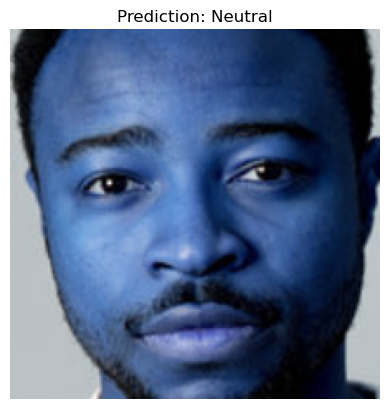

In [ ]:
# Example usage
file_path = "~/Downloads/EmotionBasedMusicRecommendationSystem/EmotionBasedMusicRecommendationSystem/uploads/360_F_246149382_KHkt8Mw8pptlmVuiqmhavvHBC4SEqBu1.jpg"
pred_and_plot(file_path, Emotion_Classes)